# 1 Sampling from large particle dataset

Import the necessary libraries:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import os
import seaborn as sns
from tqdm import tqdm
import math as m
from scipy.interpolate import UnivariateSpline
from scipy.stats import gaussian_kde
from scipy.integrate import quad
from matplotlib.ticker import ScalarFormatter

Set the background color of figures to white as default when saving:

In [80]:
plt.rcParams['savefig.facecolor']='white'

## 1.1 Read in and prepare the data

Read in the particle data stored as csv file (output of ImageJ-ParticleSizer analysis) and save them as dataframe.

In case of one csv file:

In [2]:
frame = pd.read_csv('ParticleSizer_data.csv')
print (frame)

              Frame  Label       X       Y    Area  Area Conv. Hull   Peri.  \
0          1      1      1  2.3694  0.0134  0.0001           0.0001  0.0384   
1          2      1      2  0.5286  0.0149  0.0002           0.0002  0.0493   
2          3      1      3  0.6986  0.0175  0.0002           0.0003  0.0551   
3          4      1      4  2.0906  0.0200  0.0003           0.0003  0.0596   
4          5      1      5  0.8212  0.0220  0.0004           0.0004  0.0680   
...      ...    ...    ...     ...     ...     ...              ...     ...   
11648  11649     10   1341  2.3250  2.4173  0.0002           0.0002  0.0479   
11649  11650     10   1342  0.4628  2.4292  0.0002           0.0002  0.0503   
11650  11651     10   1343  1.0229  2.4302  0.0002           0.0002  0.0468   
11651  11652     10   1344  2.3205  2.4322  0.0002           0.0002  0.0530   
11652  11653     10   1345  0.1563  2.4352  0.0003           0.0003  0.0599   

       Peri. Conv. Hull   Feret  ...    Circ.  Elon

In case you want to combine data from multiple csv files:

In [ ]:
frame = pd.DataFrame()
list_ = []
for csvFilename in os.listdir(os.getcwd()):
    if not csvFilename.endswith('.csv'):
        continue
    df = pd.read_csv(csvFilename)
    list_.append(df)
frame = pd.concat(list_)
print (frame)

Clean the dataframe, i.e. delete rows from frame which contain unreadable data ('not a number') or for which aspect ratio is infinity. Unify the column names of interest and create a new dataframe with only those:

In [3]:
frame.rename(columns={'Min. Feret': 'Fmin'}, inplace=True)
frame.rename(columns={'Feret': 'Fmax'}, inplace=True)
frame.rename(columns={'Area equivalent circle diameter': 'ECD'}, inplace=True)
frame.rename(columns={'Maximum inscriped circle diameter': 'MICD'}, inplace=True)
frame.rename(columns={'Aspect Ratio': 'AR'}, inplace=True)

In [4]:
frame = frame.dropna()
frame = frame[frame['AR'] != m.inf]

In [5]:
columns_to_keep = ['Fmin', 'Fmax', 'ECD', 'MICD', 'AR']  
frame=frame[columns_to_keep]

We want to output the data in unit of nanometer. In case the data was in a different unit (e.g. micrometer) convert the columns of interest to nanometer (e.g. x1000).

In [6]:
frame['Fmin'] = frame['Fmin'].multiply(1000)
frame['Fmax'] = frame['Fmax'].multiply(1000)
frame['ECD'] = frame['ECD'].multiply(1000)
frame['MICD'] = frame['MICD'].multiply(1000)

## 1.2 Full dataset statistics + histogram

Calculate the statistics of the Fmin, Fmax, ECD, MICD and AR measurands and write to a file:

In [ ]:
def calculate_statistics(df, output_file):
    # Specify the percentiles to be calculated
    percentiles = [0.10, 0.25, 0.50, 0.75, 0.90]
    
    # Use describe to get statistics including specified percentiles
    desc = df.describe(percentiles=percentiles).T
    
    # Calculate IQR (Interquartile Range)
    desc['IQR'] = desc['75%'] - desc['25%']
    
    # Calculate IQR%
    desc['IQR%'] = desc['IQR'] / desc['50%'] * 100
    
    # Re-arrange the DataFrame to include IQR and IQR% in the output
    stats_df = desc[['count', 'mean', 'std', 'min', '10%', '25%', '50%', '75%', '90%', 'max', 'IQR', 'IQR%']]
    
    # Transpose so that statistical measures are rows and columns are original DataFrame columns
    stats_df = stats_df.T
    
    # Write the result to a CSV file
    stats_df.to_csv(output_file)

In [ ]:
calculate_statistics(frame, 'Full_set_statistics.csv')

Set the measurand + unit you want to plot the histogram for:

In [43]:
measurand = 'Fmin'
unit = '(nm)'

Define the function to plot the histogram. The function contains a boolean 'PercentileLines' to determine whether vertical lines at the positions of the d10, d25, d50, d75, d90 should be drawn on the histogram. 

In [73]:
def plotHistogram(df, PercentileLines: bool):
    hist = sns.histplot(df, label='N = ' + str(len(df.index)), bins = 'fd') #bins according to Freedman-Diaconis rule
    #plt.rcParams["figure.figsize"] = (8.475,6.675)
    plt.xlabel(measurand + ' ' + unit, fontsize = 20)
    plt.ylabel('Count', fontsize=20)
    #plt.xlim(0,35)
    #plt.ylim(0,500)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=14)
    plt.tight_layout()
    
    #if PercentileLines is True, the next few lines of code will plot vertical lines on the histogram at the position of the different percentiles
    if PercentileLines:
        perc_txt = ['d10', 'd25', 'd50', 'd75', 'd90']
        percs = [df.quantile(0.1), df.quantile(0.25), df.quantile(0.5), df.quantile(0.75), df.quantile(0.9)]
        max_y_value = max([p.get_height() for p in hist.patches])
        for i, p in enumerate(percs):
            plt.axvline(x = p, color = 'k', linestyle = '--')
            plt.text(p - (percs[0]/10), max_y_value - (max_y_value/8), perc_txt[i], rotation = 'vertical', fontsize = 14)
    
    plt.savefig(measurand + '_hist_N=' + str(len(df.index)) +'.png', dpi = 200)
    

Plot the histogram of e.g. Fmin:

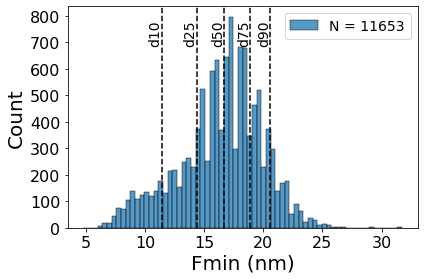

In [81]:
plotHistogram(frame[measurand], True)

## 1.3 Sampling subdatasets of increasing particle size N

Create a list of N values between 10 and the max of the full data set. For each of these values a subdataset will be sampled later.

In [7]:
# Create a list of 80 integers logaritmically spaced between 10 and 10^4
n=np.logspace(1, 4, num=80, dtype='int')

# Delete the numbers which are larger than the size of the original dataset and append the number equal to the size of the dataframe which is the max sampling N
n=n[n< len(frame)]
if(n[-1]<10000): n=np.append(n, len(frame))
    
# Delete repeating numbers
n=np.unique(n)

In [8]:
print(frame)

       Fmin  Fmax   ECD  MICD      AR
0       9.6  14.6  12.3  10.2  1.5000
1      14.8  16.9  15.8  14.4  1.0853
2      15.6  19.9  17.8  15.7  1.2308
3      17.9  20.8  19.2  17.8  1.0230
4      20.3  23.3  22.0  20.9  1.1176
...     ...   ...   ...   ...     ...
11648  13.2  17.8  15.4  13.4  1.3182
11649  14.4  18.3  16.4  15.2  1.1667
11650  14.1  16.3  15.0  14.0  1.0414
11651  16.0  18.0  17.3  16.3  1.1053
11652  18.2  20.7  19.3  17.3  1.0161

[11653 rows x 5 columns]


Construct a function to create subsamples of measured particles of increasing size N for a chosen number of samples per N. Return dataframes where for each N, the mean, std and relative std. Run the function for 500 subsamples.

In [9]:
def SubSampling(df, numSamplesPerNumParticles: int):
    # create an empty numpy array of objects with size equal to the number of columns in the dataframe, i.e. the number of measurands
    measurands = df.columns.values
    print(measurands)
    stats = np.empty(len(measurands), dtype=object)

    for i in tqdm(n):    # tqdm shows a status bar for the for loop in the console + time estimate
        for j in range(0, numSamplesPerNumParticles):
            df_s = df.sample(n=i, replace=True)
            for k,m in enumerate(measurands):
                # calculate the statistics including percentiles of the subsample
                stats_temp = df_s[m].describe(percentiles=[0.05, 0.10, 0.25, 0.5, 0.75, 0.9, 0.95])
                
                # Add the statistics calculated for each N and for each sample to a dataframe
                stats[k] = pd.concat([stats[k], stats_temp.to_frame().transpose()], ignore_index=True)
    
    # calculate the dataframes grouped by "count"(=particle number N), where the mean, std and U_N (saved as <lambda_0>) of the different samples at each N are calculated and store them in a list 
    data_out = []
    for s in range(0, len(stats)):
        data_out.append(stats[s].groupby("count").agg([np.mean, np.std, lambda x: 2*100* (np.std(x) / np.mean(x))]))
        
    return data_out

In [10]:
SamplingData = SubSampling(frame, 500)

['Fmin' 'Fmax' 'ECD' 'MICD' 'AR']


100%|██████████| 79/79 [07:17<00:00,  5.54s/it]


Define a function to rename the percentile columns in the sampling data:

In [11]:
def RenamePercCols(df):
    df.rename(
        columns={'5%': 'D5', '10%': 'D10', '25%': 'D25', '50%': 'D50', '75%': 'D75', '90%': 'D90', '95%': 'D95'},
        inplace=True,
)
    return

Apply the above generated function and save the dataframes as csv files for each measurand:

In [12]:
for i, fr in enumerate(SamplingData):
    RenamePercCols(fr)
    measurand = frame.columns[i]
    fr.to_csv('SubSampling_Stats_'+measurand+'.csv')

# 2 Plotting and fitting relation between N and U_N

The uncertainty related to particle number U_N is defined at each N by the relative std of the characteristic calculated based on the subsamples. It is expressed with a confidence interval of 95% (k=2). We will now plot the relation between N and U_N and determine the number of particles required to reach specific values of U_N by fitting the relation. Let's say we wanna do this for the Fmin.

First, let's read in the subsampling data produced in section 1.

In [13]:
#os.chdir('..')
os.getcwd()

'C:\\Users\\ChWo3222\\Desktop\\MyNotebooks\\NumPar'

In [14]:
measurand = 'Fmin' # choose Fmin, Fmax, ECD, MICD, AR or other
data = pd.read_csv('SubSampling_Stats_'+measurand+'.csv', header=[0, 1], index_col=0)

Make a new folder to save the generated output plots and change the directory to it:

In [15]:
folder = measurand + '_output'
#os.makedirs(folder) # comment this line when the folder already exists
os.chdir(folder)

## 2.1 Plotting

Defining a function that plots a specific column (defined by two columns titles column = D10, D50, etc.., par = mean, std, <lambda_0>) of a dataframe df.

In [83]:
def plot_datacolumn(df, column: str, par: str):
    
    if par == '<lambda_0>': 
        par_l = r'$U_{\rm N}$'
        unit = '(%)'
    elif par == 'mean':
        par_l = 'Mean'
        unit = '(nm)'
    elif par == 'std':
        par_l = 'Std'
        unit = '(nm)'
    else:
        par_l = par
        unit = ''
    
    plt.figure(facecolor='white')
    plt.semilogx(df.index, df[column, par], '.', label=column)
    plt.ylabel(par_l + ' ' + unit, fontsize=20)      
    plt.xlabel(r'$N$', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim(10,df.index[-1])
    plt.legend(fontsize = 14)
    plt.tight_layout()
    #plt.title(material +' ' + measurand, fontsize=25)
    #plt.savefig('RelativeStd_' + column + 'percentile_vsN_' + parameterLabel +'.jpeg', dpi = 100)
    #plt.show()
    #plt.clf()

Plot the mean and U_N as a function of N:

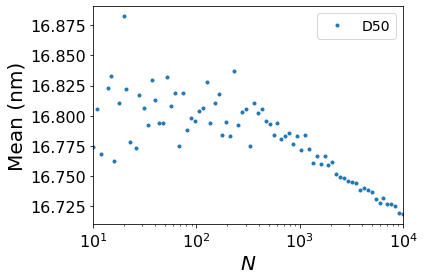

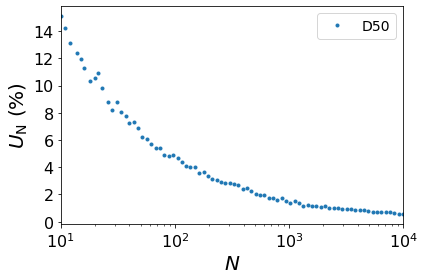

In [84]:
plot_datacolumn(data, 'D50', 'mean')
plt.show()
plot_datacolumn(data, 'D50', '<lambda_0>')
plt.show()

Plot U_N of all percentiles as a function of N on one plot:

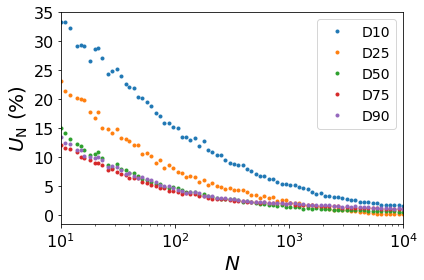

In [18]:
perc=['D10', 'D25', 'D50', 'D75', 'D90']
for p in perc:
    plot_datacolumn(data, p, '<lambda_0>')
plt.show()

Do the same but on a logscale for the y axis as well:

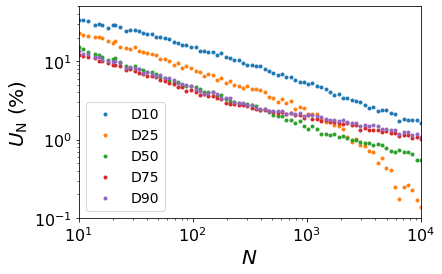

In [19]:
perc=['D10', 'D25', 'D50', 'D75', 'D90']
for p in perc:
    plot_datacolumn(data, p, '<lambda_0>')
plt.yscale('log')
plt.ylim(0.1,50)
plt.show()

## 2.2 Fitting U_N using UnivariateSpline

Set parameter for which you wanna do the fitting:

In [20]:
par = 'D50'

In [21]:
xs = np.linspace(1, 4, 1000)
xs_f = 10**xs
xs_f = xs_f[xs_f<=data.index[-1]]

In [22]:
def smoothCurve(df, column, smoothing):
    xlogScale = np.log10(df.index)  #x data need to be converted to linear scale for the spline to work
    s = UnivariateSpline(xlogScale, df[column, '<lambda_0>'], s = smoothing) #s = smoothing factor, the higher the more smoothing is applied

    ys = s(xs)
    ys_f = ys[0:len(xs_f)]
    
    plt.plot(xs_f, ys_f, 'k-')
    plot_datacolumn(df, column, '<lambda_0>')
    plt.xscale('log')
    #plt.savefig('RelativeStd_' + column + 'percentile_vsN_' + parameterLabel +'_smoothCurve.png', dpi = 300)
    plt.tight_layout()
    plt.show()
    #smo.append(smoothing)
    return ys_f

Adapt the smoothing value until a nice smooth curve fit is obtained. Increasing the value will make the curve more smooth.

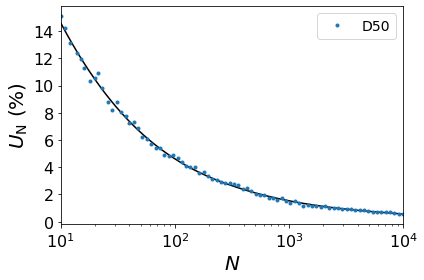

array([14.5962811 , 14.54867752, 14.50120258, 14.45385607, 14.4066378 ,
       14.35954756, 14.31258515, 14.26575036, 14.21904299, 14.17246285,
       14.12600972, 14.0796834 , 14.03348369, 13.98741039, 13.94146329,
       13.8956422 , 13.8499469 , 13.8043772 , 13.75893289, 13.71361377,
       13.66841964, 13.62335029, 13.57840553, 13.53358513, 13.48888892,
       13.44431668, 13.3998682 , 13.35554329, 13.31134175, 13.26726336,
       13.22330793, 13.17947526, 13.13576514, 13.09217736, 13.04871173,
       13.00536805, 12.9621461 , 12.91904569, 12.87606661, 12.83320867,
       12.79047165, 12.74785536, 12.70535959, 12.66298413, 12.6207288 ,
       12.57859337, 12.53657766, 12.49468145, 12.45290455, 12.41124675,
       12.36970785, 12.32828764, 12.28698593, 12.2458025 , 12.20473716,
       12.16378971, 12.12295993, 12.08224764, 12.04165261, 12.00117466,
       11.96081358, 11.92056917, 11.88044122, 11.84042952, 11.80053389,
       11.76075411, 11.72108998, 11.6815413 , 11.64210786, 11.60

In [28]:
smoothing = 3
smoothCurve(data, 'D50', smoothing)

The next lines of code will do the smoothing for each of the percentiles of the choses measurand at the same time and save the output curves in the array sC:

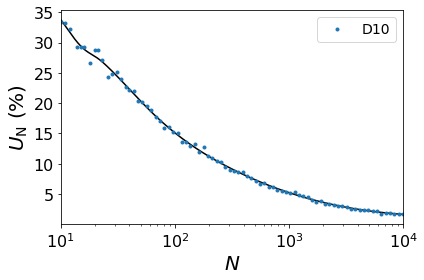

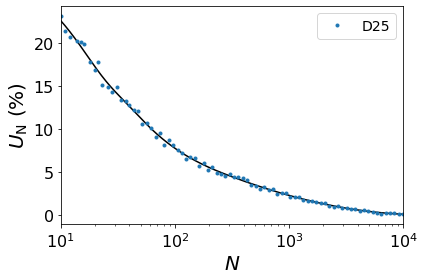

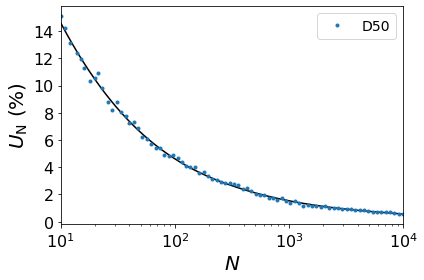

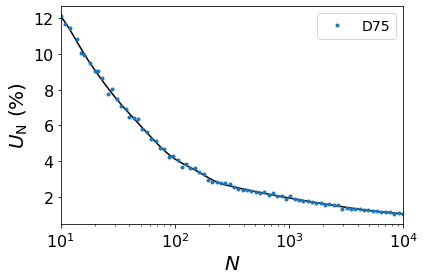

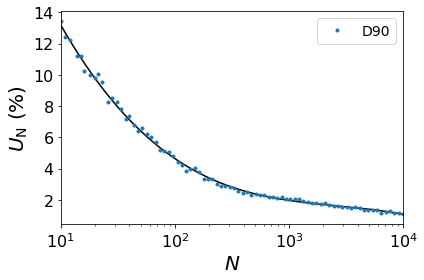

In [31]:
smo_list = [15, 8, 3, 0.7, 2]
perc=['D10', 'D25', 'D50', 'D75', 'D90']
sC = [0]*len(perc)

for i, p in enumerate(perc):
    sC[i] = smoothCurve(data, p, smo_list[i])

# 3 Determining N_m from the spline curve

Define the function to calculate Nm for a predefined precision (=U_N) based on the smooth spline curve:

In [32]:
def det_Nm(precision, ys):
    #xs = np.linspace(1, 4, 1000)
    if ys[0] < precision:
        #return 10  # return 10 instead of NaN when Nm is actually lower than 10  --> for Nm vs. IQR/d50 plot
        return np.nan
    else:
        idx = np.argwhere(np.diff(np.sign(precision - ys))).flatten()
        
        if not idx.size > 0:
            return np.nan
        else:
            idx = idx[0]
            Nm_lin=xs[idx]
            Nm=m.ceil(10**Nm_lin)
            #print(Nm)
            return Nm

Set a set of U_N values for which you want to calculate Nm and initiate a dataframe to save the Nm values for each value of U_N:

In [33]:
UN_out=[40, 30, 20, 15, 10, 8, 6, 5, 4, 3, 2, 1]
df_Nm = pd.DataFrame()
df_Nm['U_N']=UN_out

Apply the det_Nm function for each element of the U_N array and for each of the percentiles. Save the Nm dataframe to a csv file:


In [34]:
for i, p in enumerate(perc):
    c = sC[i]
    N=[]
    for U in UN_out:
        N.append(det_Nm(U, c))
    print(N)
    df_Nm[p]=N

[nan, 15, 53, 102, 258, 422, 764, 1087, 1657, 2802, 6163, nan]
[nan, nan, 15, 28, 63, 95, 170, 250, 396, 666, 1223, 2652]
[nan, nan, nan, nan, 22, 34, 60, 86, 133, 241, 568, 2615]
[nan, nan, nan, nan, 17, 27, 50, 70, 107, 206, 871, nan]
[nan, nan, nan, nan, 19, 32, 58, 85, 138, 269, 921, nan]


In [35]:
df_Nm.to_csv('Nm_table_'+measurand+'.csv')

# 4 Output plot(s)

## 4.1 Nm vs UN

In [36]:
measurand = 'Fmin'

Read in the Nm data generated in section 3.

If needed first go the right directory:

In [37]:
print(os.getcwd())

C:\Users\ChWo3222\Desktop\MyNotebooks\NumPar\Fmin_output


In [ ]:
os.chdir('..')
folder = measurand + '_output'
#os.makedirs(folder) # comment this line when the folder already exists
os.chdir(folder)

In [38]:
plot_data = pd.read_csv('Nm_table_'+measurand+'.csv', header=[0], index_col=0)

In [39]:
plot_data

,U_N,D10,D25,D50,D75,D90
0,40,NaN,NaN,NaN,NaN,NaN
1,30,15.0,NaN,NaN,NaN,NaN
2,20,53.0,15.0,NaN,NaN,NaN
3,15,102.0,28.0,NaN,NaN,NaN
4,10,258.0,63.0,22.0,17.0,19.0
5,8,422.0,95.0,34.0,27.0,32.0
6,6,764.0,170.0,60.0,50.0,58.0
7,5,1087.0,250.0,86.0,70.0,85.0
8,4,1657.0,396.0,133.0,107.0,138.0
9,3,2802.0,666.0,241.0,206.0,269.0


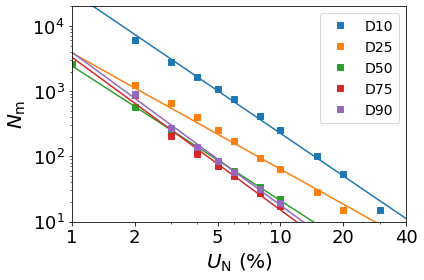

In [57]:
key_list = list(plot_data)
key_list.remove('U_N')

x_fit = np.arange(-1, 3)
color = ['C0', 'C1', 'C2', 'C3', 'C4']
#marker = ['o','s','v','^','<','>','p','P','*']
fig, ax = plt.subplots(facecolor=(1, 1, 1))


for k, c in zip(key_list, color):  
    df_sub = pd.DataFrame()
    df_sub['U_N'] = plot_data['U_N']
    df_sub['Nm'] = plot_data[k]
    df_sub = df_sub.dropna()
    #print(df_sub)
    
    plt.plot(df_sub['U_N'], df_sub['Nm'], ls='None', marker ='s', color=c, label=k)
    #plt.plot(df_sub['U_N'], df_sub['Nm'], label=k, ls='None', markerfacecolor='white',
    #     markeredgewidth=2, markeredgecolor='k', markersize=9)
    
    if len(df_sub)>1:
        z = np.polyfit(np.log10(df_sub['U_N']), np.log10(df_sub['Nm']), 1)
        p = np.poly1d(z)
        plt.plot([0.1, 1, 10, 100], 10**(p(x_fit)), '-', color=c)

        
plt.xlabel(r'$U_{\rm N}$ ($\%$)', fontsize=20)
plt.ylabel(r'$N_{\rm m}$', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,40)
plt.ylim(10,2*10**4)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks([1,2,5,10, 20, 40])
plt.legend(fontsize = 14)
plt.tight_layout()
plt.savefig('NumPar_vs_UN_'+measurand+'_.png', dpi=200)
